# GMM – Wine Quality (Vin rouge)

Ce notebook applique **GMM (Gaussian Mixture Models)** selon les bonnes pratiques ML :
- Clustering **probabiliste** (soft assignment)
- Alternative à K-Means avec clusters de forme elliptique
- Détection du nombre optimal de composantes via BIC
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable.")
from preprocessing import load_data, clean_data, scale_features
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import mlflow

mlflow.set_experiment("wine-quality-gmm")

2026/02/14 17:34:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:34:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:34:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:34:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:34:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:34:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:34:08 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:34:08 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/clustering/mlruns/4', creation_time=1771082930174, experiment_id='4', last_update_time=1771082930174, lifecycle_stage='active', name='wine-quality-gmm', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

X = df.drop(columns=["quality"])
y = df["quality"]

X_scaled, scaler = scale_features(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Dataset shape: {df.shape}")

Dataset shape: (1359, 12)


## 3. Sélection du nombre de composantes (BIC)

C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\pc\anaconda3\envs\mlflow_env\lib\subprocess.py", line 971, in __init__
    sel

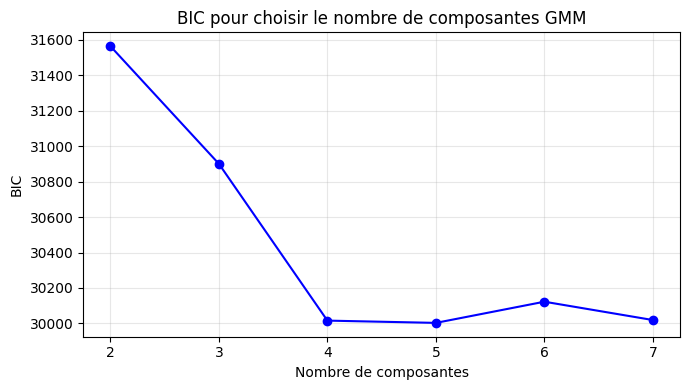

Nombre optimal (BIC minimal): 5


In [3]:
bics = []
n_components_range = range(2, 8)
for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))

plt.figure(figsize=(7, 4))
plt.plot(list(n_components_range), bics, 'bo-')
plt.xlabel('Nombre de composantes')
plt.ylabel('BIC')
plt.title('BIC pour choisir le nombre de composantes GMM')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gmm_bic.png')
_cwd = os.getcwd()
plt.savefig('gmm_bic.png')
plt.show()

optimal_k = list(n_components_range)[np.argmin(bics)]
print(f"Nombre optimal (BIC minimal): {optimal_k}")

## 4. Application GMM

In [4]:
n_components = 4
gmm = GaussianMixture(n_components=n_components, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

sil_gmm = silhouette_score(X_scaled, labels_gmm)
print(f"Silhouette score (k={n_components}): {sil_gmm:.3f}")

Silhouette score (k=4): 0.045


## 5. Visualisations

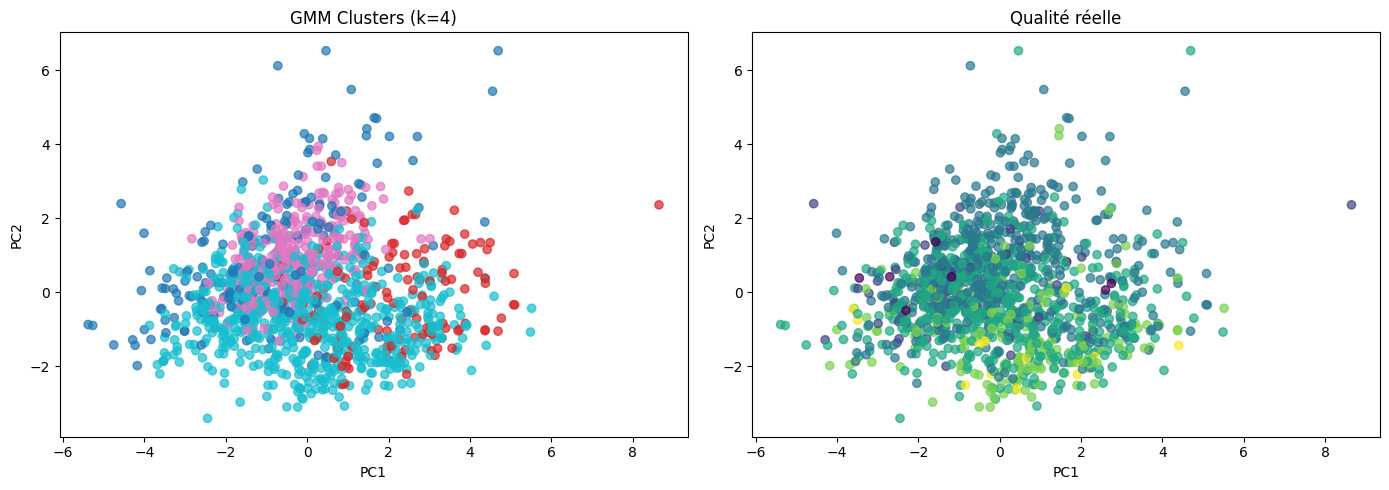

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_gmm, cmap='tab10', alpha=0.7)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'GMM Clusters (k={n_components})')

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Qualité réelle')

plt.tight_layout()
plt.savefig('gmm_clusters.png')
plt.savefig('gmm_clusters.png')
plt.show()

## 6. MLflow tracking

In [6]:
with mlflow.start_run(run_name="GMM_4components"):
    mlflow.log_param("n_components", n_components)
    mlflow.log_metric("silhouette_score", float(sil_gmm))
    mlflow.log_metric("bic", float(gmm.bic(X_scaled)))
    if os.path.exists('gmm_clusters.png'):
        mlflow.log_artifact('gmm_clusters.png')
    print("MLflow run terminé")

MLflow run terminé
